# Tranzakciós adat
A 'rendes' idősorhoz képest annyival bonyolultabb, hogy nem rendszeres időközönként, hanem eseményenként kapjuk az adatot.


## Tesco törzsvásárló adat

- Aki az év első és utolsó hónapjában kezdeményezett tranzakciót
- Fakultatív házi: kitalálni, hogy milyen országnak az adatai ezek (nemzeti ünnepek alapján)
- 'day': a 2010 Április 1-től számított napok száma

## Regressziós feladat

A 200-adik nappal kezdődő hét napban összesen mennyit fog költeni a vásárló.

Lehetséges modellek:
- Lineáris regresszió
- K legközelebbi szomszéd
- Döntési fa
- Kombinált modellek: random boosting

Lehetséges jó módszerek a becslésre:
- előző hét költése
- előző hét/hónap/év azonos időszaka (hónapra megnézték, nem működik ennél a példánál, illetve nincs adat)
- addigi teljes forgalom
- látogatások száma
- teljesen forgalom: átlagos nap/átlagos vásárlás
- napok eloszlása

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../data/DataSet_Tesco5000_withDaynum.csv")

In [15]:
df.shape

(596733, 4)

In [4]:
df.head()

customer_id  visit_date  visit_spend  daynum
0            2  2010-04-01         5.97       0
1            2  2010-04-06        12.71       5
2            2  2010-04-07        34.52       6
3            2  2010-04-12         7.89      11
4            2  2010-04-14        17.17      13

In [17]:
def idoablak_statisztika(nap_tol,nap_ig,ujnev,aggreg_fuggveny=np.mean,valtozo="visit_spend"):
    """
    Két nap közötti értékekre aggregál a customer id alapján.
    """
    adf = df[  (df['daynum']>=nap_tol) & (df['daynum']<nap_ig) ]
    
    agg_obj = adf.groupby('customer_id',as_index=False)
    
    stat = agg_obj[valtozo].agg(aggreg_fuggveny)
    stat.columns=['customer_id',ujnev]
    return stat

In [51]:
def cel_es_bemenet_generalasa(hataridopont):
    """
    """
    # Lefuttatjuk a fenti függvényt:
    alap = idoablak_statisztika(hataridopont,hataridopont+7,'target',np.sum)
    
    # Az egész adathalmazban megnézi, hogy kinek hány tranzakciója van
    alap2 = df.groupby('customer_id',as_index=False)['visit_spend'].agg(len)
    
    # Mergreljük a két táblát
    alap3 = alap2.merge(alap,on='customer_id',how='left')
    alap3['target']=alap3['target'].fillna(0)
    del alap3['visit_spend']
    alap = alap3.copy()

    # Elozo heti koltes
    ujnev = 'elozo_heti_koltes'
    uj = idoablak_statisztika(hataridopont-7,hataridopont, ujnev,np.sum)
    alap = alap.merge(uj, on="customer_id", how='left')
    alap[ujnev] = alap[ujnev].fillna(0)
    
    # Elozo heti koltesszam
    ujnev = 'elozo_heti_koltesszam'
    uj = idoablak_statisztika(hataridopont-7,hataridopont, ujnev, len)
    alap = alap.merge(uj, on="customer_id", how='left')
    alap[ujnev] = alap[ujnev].fillna(0)
    
    # Elozo heti koltes
    ujnev = 'negy_hettel_ezelotti_koltes'
    uj = idoablak_statisztika(hataridopont-7*4,hataridopont-7*3, ujnev, np.sum)
    alap = alap.merge(uj, on="customer_id", how='left')
    alap[ujnev] = alap[ujnev].fillna(0)
    
    # Atlagos napi koltes
    ujnev = 'atlagos_napi_koltes'
    uj = idoablak_statisztika(0,hataridopont, ujnev, np.sum)
    alap = alap.merge(uj, on="customer_id", how='left')
    alap[ujnev] = alap[ujnev].fillna(0)
    alap[ujnev] = alap[ujnev] / hataridopont
    
    return alap

In [52]:
elso_idougras = 200

In [53]:
xdf = cel_es_bemenet_generalasa(elso_idougras)

In [54]:
xdf.head(30)

customer_id  target  elozo_heti_koltes  elozo_heti_koltesszam  \
0             2   33.25               1.50                    1.0   
1             3   96.24              70.39                    3.0   
2             4  211.95             156.01                    2.0   
3             5   79.87              93.71                    3.0   
4             6   51.66              57.03                    1.0   
5             7    0.00             159.36                    1.0   
6             8   82.58             113.61                    4.0   
7            11   18.90              20.39                    1.0   
8            12   99.89              83.14                    2.0   
9            14   46.28               0.00                    0.0   
10           16  113.13             264.28                    3.0   
11           17  110.45             110.57                    2.0   
12           19   77.55              71.29                    2.0   
13           20  162.56              84.81                    2.0   
14           21  132.47              79.16                    2.0   
15           22   63.79              55.20                    3.0   
16           23    0.89               8.62                    1.0   
17           26   27.28              26.88                    2.0   
18           27    1.50              23.13                    3.0   
19           29   92.50              85.70                    6.0   
20           30    9.98              86.54                    4.0   
21           31    0.00             130.11                    2.0   
22           32    0.00             128.43                    1.0   
23           33   94.47             105.00                    2.0   
24           34  166.64              23.99                    2.0   
25           35   88.19             292.16                    3.0   
26           36   55.21             100.04                    2.0   
27           37  140.29              44.89                    1.0   
28           39   24.98             108.21                    2.0   
29           41  109.97              69.80                    3.0   

    negy_hettel_ezelotti_koltes  atlagos_napi_koltes  
0                         80.28              4.85495  
1                         91.05              9.85685  
2                          0.00             25.06170  
3                          0.00              9.04375  
4                         34.40              8.41935  
5                          0.00             11.09950  
6                        120.28             12.88285  
7                         56.56              6.05600  
8                        135.92             12.60730  
9                         31.59              6.81410  
10                       180.77             22.66640  
11                       142.67             18.15530  
12                        26.36              5.75380  
13                        64.26             17.19565  
14                         0.00              6.12480  
15                       109.52              8.88775  
16                         0.00              5.99955  
17                        86.02              5.84665  
18                        75.67              4.77630  
19                       144.42             22.24675  
20                        37.21              5.70460  
21                        35.60              6.38310  
22                         0.00              9.90510  
23                         0.00              8.10300  
24                       100.70             10.84680  
25                       107.98             18.94690  
26                       151.49             16.34380  
27                       123.92              6.89550  
28                       128.06             20.06425  
29                        22.42             12.23110

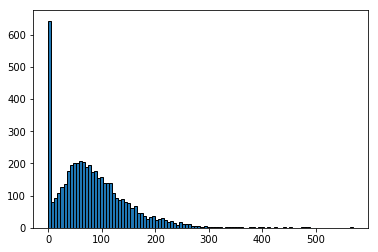

In [55]:
_,_,_=plt.hist(xdf['target'],bins=100)

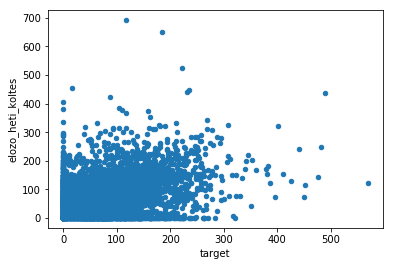

In [56]:
xdf.plot('target', 'elozo_heti_koltes', kind='scatter')

# Modellezés
1. Test-train split
2. GBM építés
3. GBM alkalmazás
4. MAPE számítás

## Test-train split

In [58]:
celvaltozo = 'target'
bemeno_valtozo = list(xdf.columns[2:])

In [59]:
bemeno_valtozo

['elozo_heti_koltes',
 'elozo_heti_koltesszam',
 'negy_hettel_ezelotti_koltes',
 'atlagos_napi_koltes']

In [ ]:
from sklearn.cross_validation import train_test_split

In [61]:
train_df, test_df = train_test_split(xdf, test_size=0.5, random_state=42)

In [64]:
train_df.shape

(2500, 6)

In [ ]:
test_df.shape

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

In [69]:
model = GradientBoostingRegressor(n_estimators=100)

In [71]:
model.fit(train_df[bemeno_valtozo], train_df[celvaltozo])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [72]:
test_df = test_df.copy()

In [73]:
test_df['tipp'] = model.predict(test_df[bemeno_valtozo])

In [74]:
test_df.head()

customer_id  target  elozo_heti_koltes  elozo_heti_koltesszam  \
1501         2251   80.00              82.68                    1.0   
2586         3835   71.75              68.52                    1.0   
2653         3934   33.74              38.91                    1.0   
1055         1583    0.00              29.97                    1.0   
705          1060   20.47               0.00                    0.0   

      negy_hettel_ezelotti_koltes  atlagos_napi_koltes       tipp  
1501                        63.48             11.20985  86.294339  
2586                        50.98              7.83290  62.018087  
2653                        25.00              4.87330  35.235044  
1055                        64.22             12.04280  84.160562  
705                          0.00              5.37295  40.784322

In [78]:
abs(test_df['tipp'] - test_df['target']).mean()

39.99350120848171

In [79]:
np.mean(test_df['target'])

82.61930799999999

A hiba amit elkövettünk: a mai napon nem tudom alkalmazni a modelt, mivel nincs adatom a jövőre vonatkozóan

Ehelyett a 200 nappal ezelőtt alkalmazható modelre a tanítást egy korábbi időpontban tudom csak megtenni.

## Modellezés II.

In [80]:
celvaltozo = 'target'
bemeno_valtozo = list(xdf.columns[2:])

In [81]:
bemeno_valtozo

['elozo_heti_koltes',
 'elozo_heti_koltesszam',
 'negy_hettel_ezelotti_koltes',
 'atlagos_napi_koltes']

In [82]:
from sklearn.cross_validation import train_test_split

In [83]:
train_df, test_df = train_test_split(xdf, test_size=0.5, random_state=42)

In [84]:
test_df = cel_es_bemenet_generalasa(elso_idougras)
train_df = cel_es_bemenet_generalasa(elso_idougras-28)

In [85]:
train_df.shape

(5000, 6)

In [86]:
test_df.shape

(5000, 6)

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

In [88]:
model = GradientBoostingRegressor(n_estimators=100)

In [89]:
model.fit(train_df[bemeno_valtozo], train_df[celvaltozo])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [90]:
test_df = test_df.copy()

In [91]:
test_df['tipp'] = model.predict(test_df[bemeno_valtozo])

In [92]:
test_df.head()

customer_id  target  elozo_heti_koltes  elozo_heti_koltesszam  \
0            2   33.25               1.50                    1.0   
1            3   96.24              70.39                    3.0   
2            4  211.95             156.01                    2.0   
3            5   79.87              93.71                    3.0   
4            6   51.66              57.03                    1.0   

   negy_hettel_ezelotti_koltes  atlagos_napi_koltes        tipp  
0                        80.28              4.85495   38.604305  
1                        91.05              9.85685   73.625102  
2                         0.00             25.06170  154.922851  
3                         0.00              9.04375   55.650571  
4                        34.40              8.41935   53.540869

In [93]:
abs(test_df['tipp'] - test_df['target']).mean()

39.115900030861276

In [94]:
np.mean(test_df['target'])

82.289952

## Modellezés III.

In [80]:
celvaltozo = 'target'
bemeno_valtozo = list(xdf.columns[2:])

In [81]:
bemeno_valtozo

['elozo_heti_koltes',
 'elozo_heti_koltesszam',
 'negy_hettel_ezelotti_koltes',
 'atlagos_napi_koltes']

In [82]:
from sklearn.cross_validation import train_test_split

In [83]:
train_df, test_df = train_test_split(xdf, test_size=0.5, random_state=42)

In [95]:
test_df = cel_es_bemenet_generalasa(elso_idougras)
train_df = cel_es_bemenet_generalasa(elso_idougras-7)

In [96]:
train_df.shape

(5000, 6)

In [97]:
test_df.shape

(5000, 6)

In [98]:
from sklearn.ensemble import GradientBoostingRegressor

In [99]:
model = GradientBoostingRegressor(n_estimators=100)

In [100]:
model.fit(train_df[bemeno_valtozo], train_df[celvaltozo])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [101]:
test_df = test_df.copy()

In [102]:
test_df['tipp'] = model.predict(test_df[bemeno_valtozo])

In [103]:
test_df.head()

customer_id  target  elozo_heti_koltes  elozo_heti_koltesszam  \
0            2   33.25               1.50                    1.0   
1            3   96.24              70.39                    3.0   
2            4  211.95             156.01                    2.0   
3            5   79.87              93.71                    3.0   
4            6   51.66              57.03                    1.0   

   negy_hettel_ezelotti_koltes  atlagos_napi_koltes        tipp  
0                        80.28              4.85495   43.880956  
1                        91.05              9.85685   69.285750  
2                         0.00             25.06170  158.794168  
3                         0.00              9.04375   57.107918  
4                        34.40              8.41935   53.242500

In [104]:
abs(test_df['tipp'] - test_df['target']).mean()

39.11965792080255

In [105]:
np.mean(test_df['target'])

82.289952

## Tanítási adatmennyiség változásának hatása

In [107]:
xt = []
yt = []
for train_size in range(100, 5001, 100):
    atrain_df = train_df.iloc[:train_size,:]
    model.fit(atrain_df[bemeno_valtozo], atrain_df[celvaltozo])
    test_df['tipp'] = model.predict(test_df[bemeno_valtozo])
    MAE = np.mean(abs(test_df['tipp']-test_df['target']))
    
    xt.append(train_size)
    yt.append(MAE)

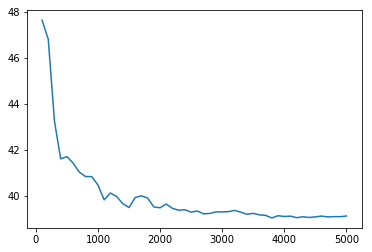

In [108]:
plt.plot(xt, yt)

## Intervallumok változtatása
Az adatmennyiségen kívül ugyanakkor ugyancsak hozzá lehet adni különböző időintervallumokat. 

In [114]:
test_df = cel_es_bemenet_generalasa(elso_idougras)
dfek = []
for i in [7, 14, 21]:
    uj_train_df = cel_es_bemenet_generalasa(elso_idougras-i)
    dfek.append(uj_train_df)
train_df = pd.concat(dfek)

In [115]:
train_df.shape

(15000, 6)

In [118]:
xt = []
yt = []
for train_size in range(1000, 15001, 1000):
    atrain_df = train_df.iloc[:train_size,:]
    model.fit(atrain_df[bemeno_valtozo], atrain_df[celvaltozo])
    test_df['tipp'] = model.predict(test_df[bemeno_valtozo])
    MAE = np.mean(abs(test_df['tipp']-test_df['target']))
    
    xt.append(train_size)
    yt.append(MAE)

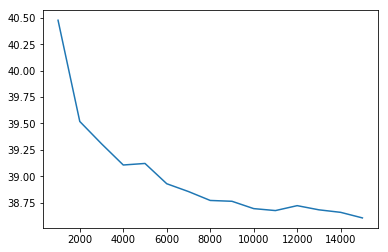

In [119]:
plt.plot(xt, yt)

Az ábra hullámzik, mivel túltanultunk pl nem költőkre vagy a korai időszakra.